# Predicting the outcome of loan applications

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

from imblearn.over_sampling import ADASYN

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# 1. Exploratory Data Analysis
We have 1000 data points.

In [2]:
df = pd.read_csv('./loan_data.csv')

In [3]:
df.head()

,checking_status,duration,loan_history,purpose,loan_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_loans,job,num_dependents,own_telephone,foreign_worker,accepted
0,<0DM,6,Critical_acct_other_loans_existing,radio/television,1169,Unknown_or_no_savings_acct,>7yrs,4,male_single,None,...,real_estate,67,none,own,m22,skilled_employee/official,1,Yes,yes,2
1,0_to_200DM,48,Existing_loans_paid_till_now,radio/television,5951,<100DM,1_to_4yrs,2,female_divorced/separated/married,None,...,real_estate,22,none,own,e1,skilled_employee/official,1,No,yes,1
2,None,12,Critical_acct_other_loans_existing,education,2096,<100DM,4_to_7yrs,2,male_single,None,...,real_estate,49,none,own,1,unskilled_resident,2,No,yes,2
3,<0DM,42,Existing_loans_paid_till_now,furniture/equipment,7882,<100DM,4_to_7yrs,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45,none,for_free,q1,skilled_employee/official,2,No,yes,2
4,<0DM,24,Delay_in_past,new_car,4870,<100DM,1_to_4yrs,3,male_single,None,...,unknown/no_property,53,none,for_free,p22,skilled_employee/official,2,No,yes,1


There are no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
loan_history              1000 non-null object
purpose                   1000 non-null object
loan_amount               1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
other_payment_plans       1000 non-null object
housing                   1000 non-null object
existing_loans            1000 non-null object
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
foreign

## Is the classification problem balanced?
We have more data about accepted applications than rejected applications, but there is no major imbalance. I will re-encode the labels in a more intuitive way where `1` indicates something that requires human attention, i.e. a rejection, while `0` suggests that everything is fine, i.e. and acceptance.

In [5]:
df['accepted'].value_counts()

2    700
1    300
Name: accepted, dtype: int64

In [6]:
df['label'] = df['accepted'].map({2: 0, 1: 1})

## Distributions and correlations of the numerical features
There are only 3 numerical features. Their distributions do not reveal any outliers or strong correlations, so it's probably a good idea to include all of them in a model.

In [7]:
NUMERICAL_FEATURES = ['duration', 'loan_amount', 'age']

In [8]:
df[NUMERICAL_FEATURES].describe()

,duration,loan_amount,age
count,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,35.546000
std,12.058814,2822.736876,11.375469
min,4.000000,250.000000,19.000000
25%,12.000000,1365.500000,27.000000
50%,18.000000,2319.500000,33.000000
75%,24.000000,3972.250000,42.000000
max,72.000000,18424.000000,75.000000


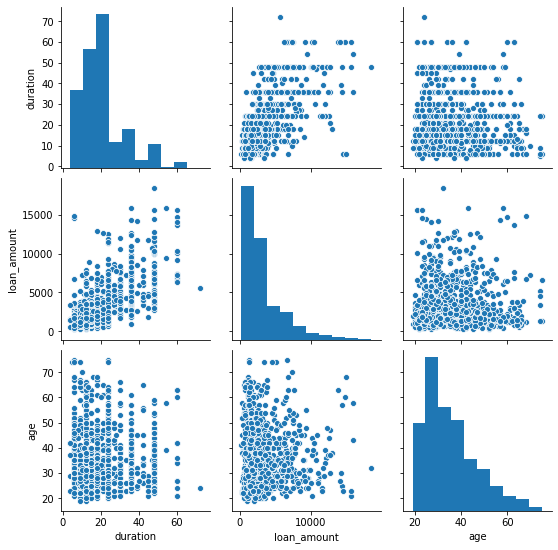

In [9]:
sns.pairplot(df[NUMERICAL_FEATURES])

## Analyse the effect of the numerical features on the outcome
Based on the plots below, we notice that all numerical features have some effect on the outcome, so we will use all of them in the modelling.

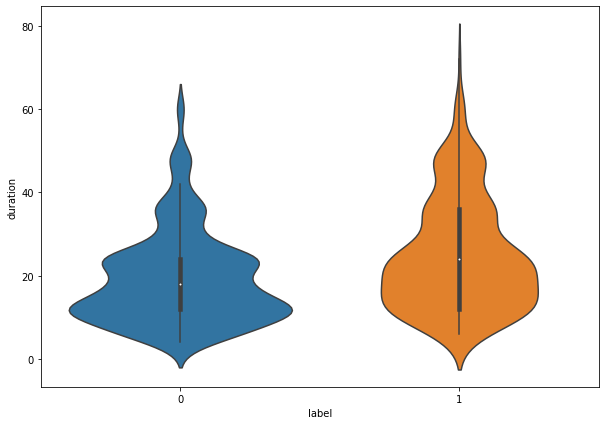

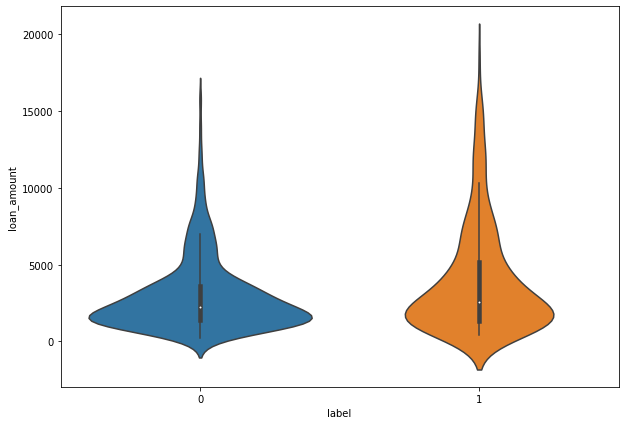

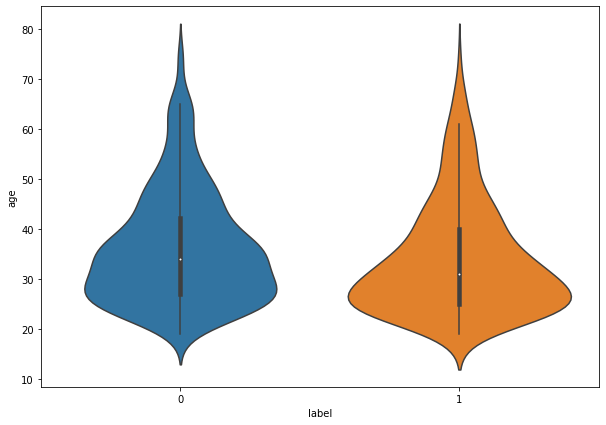

In [10]:
for f in NUMERICAL_FEATURES:
    plt.figure(figsize=(10,7))
    sns.violinplot(x='label', y=f, data=df)

## Analyse the effect of the categorical features on the outcome
We will use percentage stacked bar plots to investigate that, and see if there is anything to be learned.

In [11]:
def percentage_stacked_bar_plot(groups, outcome, data, baseline=0.7, bar_width=0.85):
    """
    Generate a percentage stacked bar plot.
    
    Parameters
    ----------
    groups: str
        Name of the categorical variable in data to analyze.
    outcome: str
        Name of the label to cluster by, encoded as integers, 
        1 for the positive class and 0 for the negative class.
    data: pandas.DataFrame
        Data frame containing the data.
    baseline: float
        Percentage of positive in the whole data set, to use as
        a reference for comparison.
    bar_width: float
        Relative width of the bars in the bar plot.

    """
    # Group counts by outcome
    green = data.loc[data[outcome]==0, groups].value_counts().sort_index().values
    orange = data.loc[data[outcome]==1, groups].value_counts().sort_index().values
    totals = data[groups].value_counts().sort_index()
    
    # From counts to percentage
    greenBars = green / totals.values
    orangeBars = orange / totals.values

    # Map bars to locations in increasing order of accept probability
    r = np.argsort(greenBars)
    loc = list(range(len(totals)))
    
    # Plot
    fig = plt.figure(figsize=(12,6))
    plt.bar(loc, greenBars[r], color='#b5ffb9', edgecolor='white', width=bar_width)
    plt.bar(loc, orangeBars[r], bottom=greenBars[r], color='#f9bc86', edgecolor='white', width=bar_width)
    plt.hlines(baseline, min(r) - bar_width/2, max(r) + bar_width/2, linestyles='dashed')
    plt.title(groups)
    # Custom x axis
    names = totals.index
    plt.xticks(loc, names[r], rotation=30, ha='right')

    

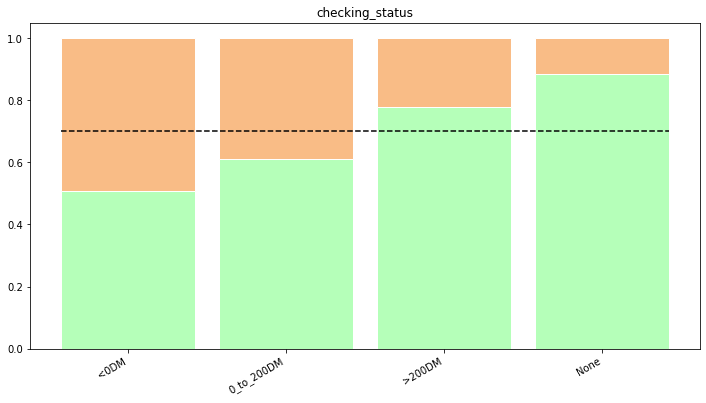

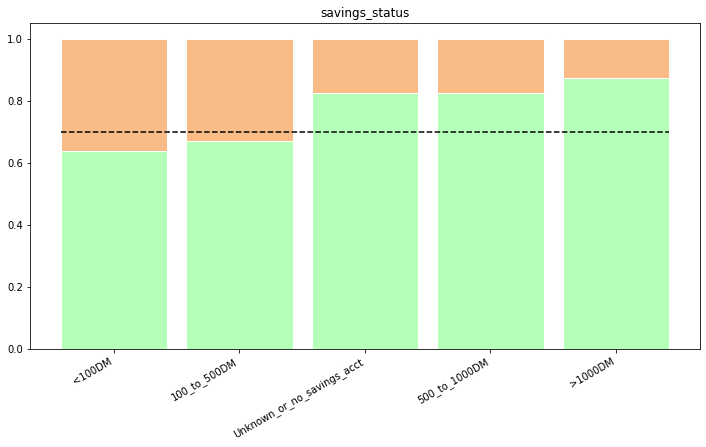

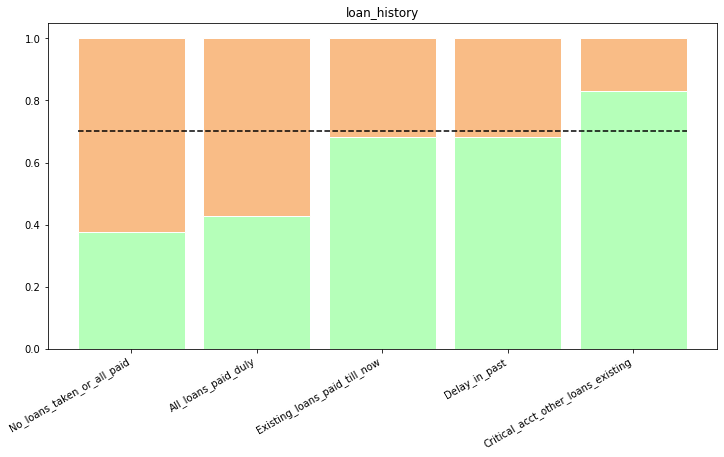

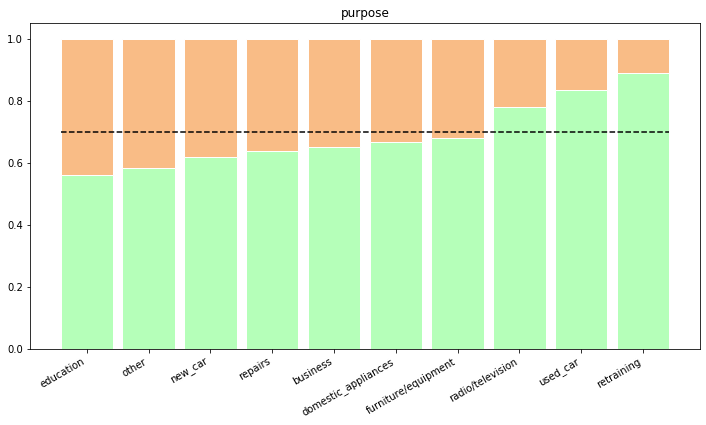

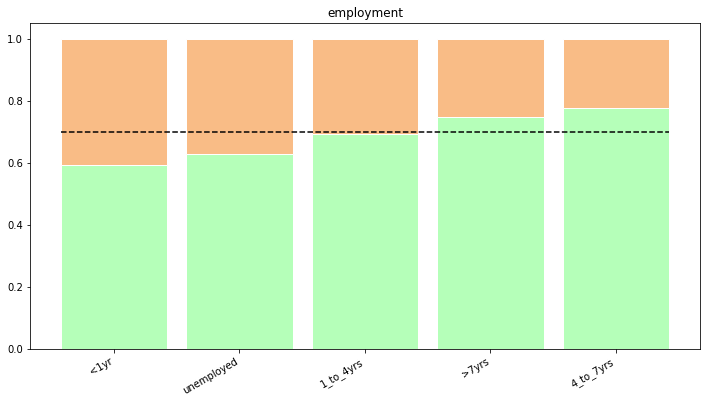

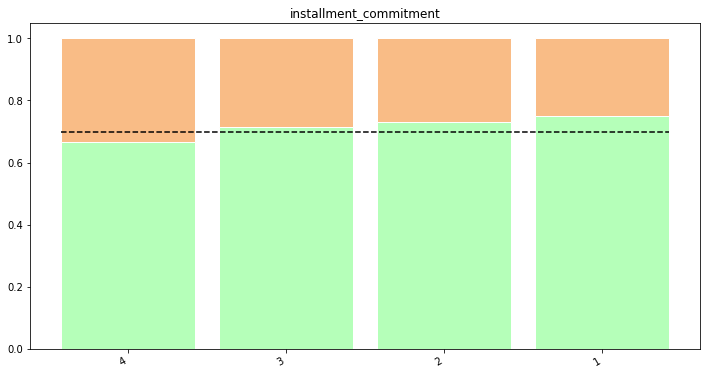

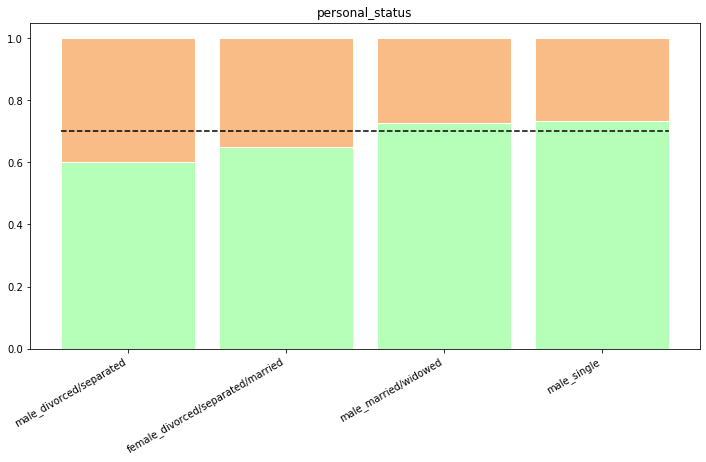

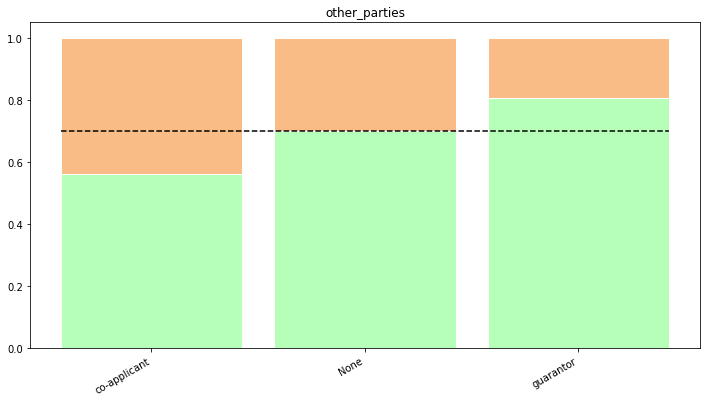

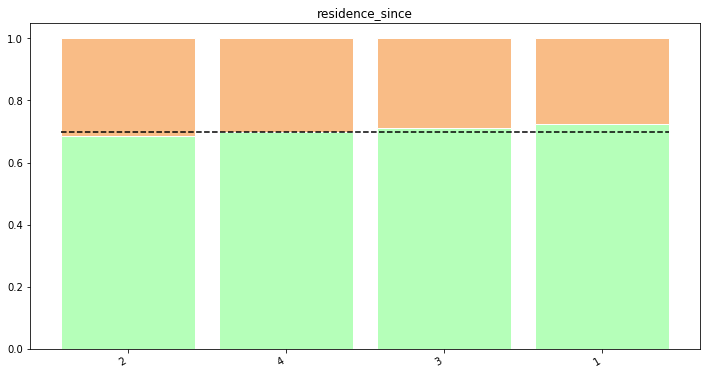

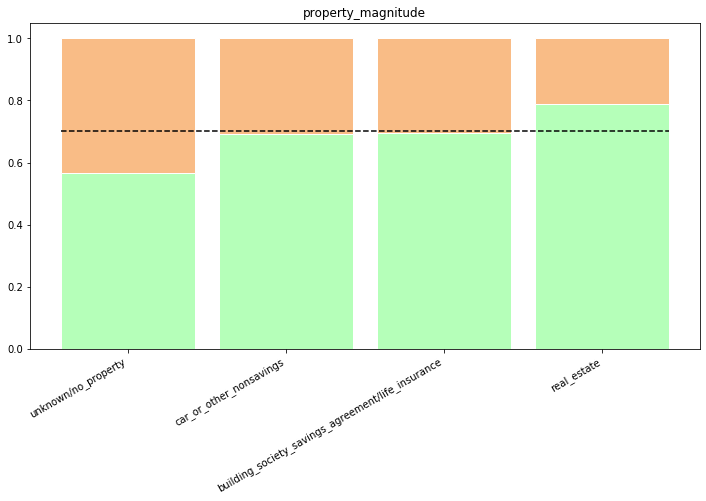

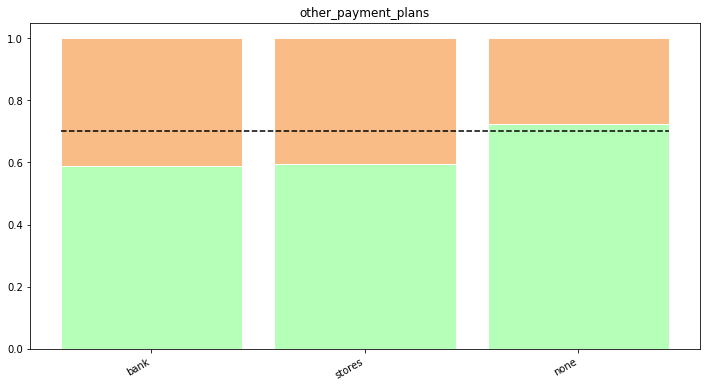

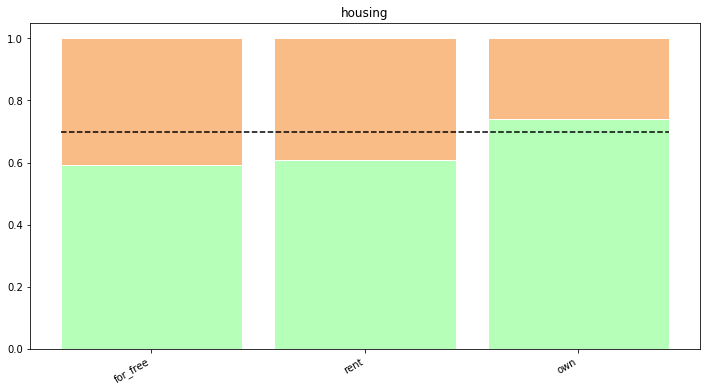

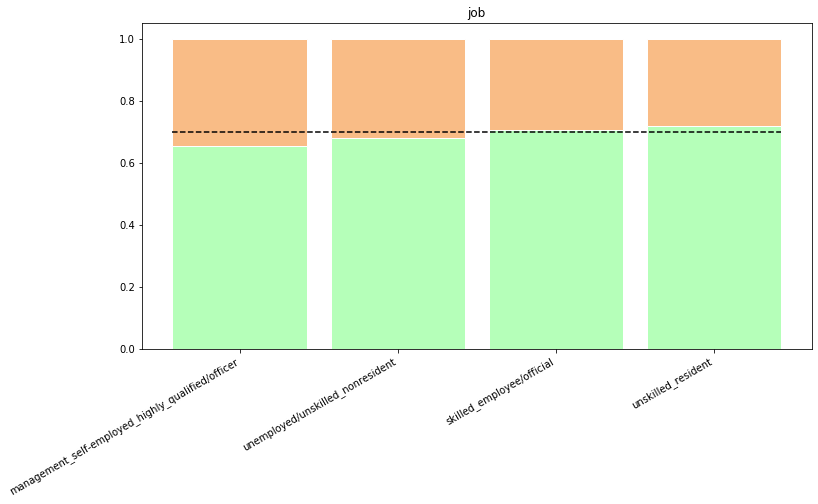

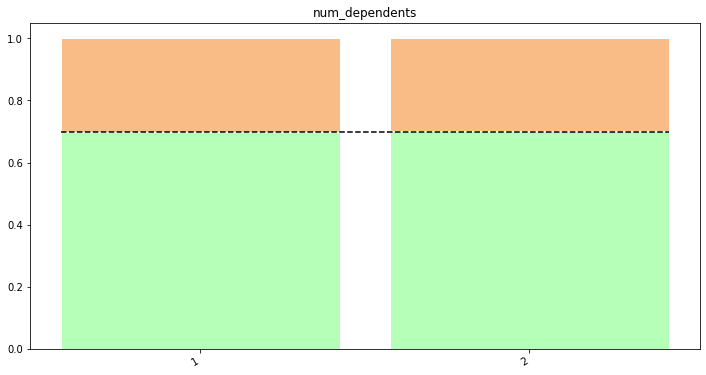

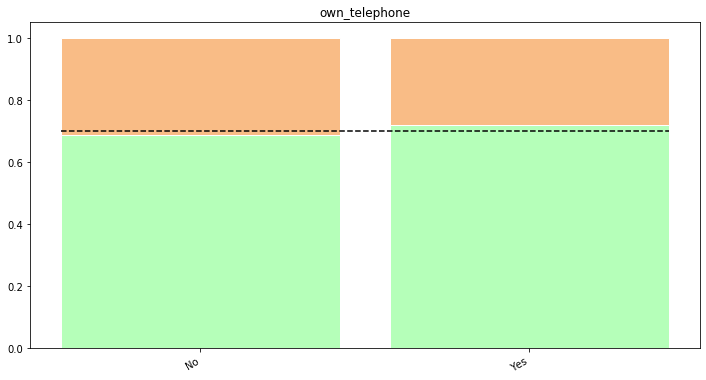

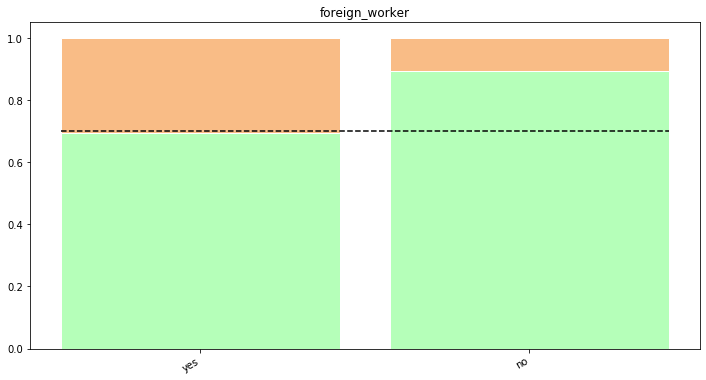

In [12]:
CATEGORICAL_FEATURES = ['checking_status', 'savings_status', 'loan_history', 'purpose',
                        'employment', 'installment_commitment', 'personal_status', 'other_parties',
                        'residence_since', 'property_magnitude', 'other_payment_plans', 'housing',
                        'job', 'num_dependents', 'own_telephone', 'foreign_worker']

for f in CATEGORICAL_FEATURES:
    percentage_stacked_bar_plot(f, 'label', df)

There are some surprising findings, which will be addressed in the presentation. But in terms of how much information the categorical features carry about the outcome, we can certainly discard some which have little or no impact. Random Forest feature importances will give further clues about this.

In [13]:
SELECTED_CATEGORICAL = ['checking_status', 'savings_status', 'loan_history', 'purpose', 'employment', 'other_parties',
                        'property_magnitude', 'other_payment_plans', 'housing', 'foreign_worker']

## The variable `existing_loans`
This is a bit problematic, because it has a lot of different levels and it's not clear what they mean. Some codes show a significant effect in term of percentage of positives. I will cluster them based on increasing percentage of positive examples in the level.

In [14]:
el_levels = pd.DataFrame(columns=['pct_positive', 'num_examples'],
                         index=df['existing_loans'].value_counts().index)

for level in df['existing_loans'].value_counts().index:
    tot_level = len(df.loc[df['existing_loans'] == level])
    positive_level = len(df.loc[(df['existing_loans'] == level) & (df['label'] == 1)])
    el_levels.loc[level] = {
        'pct_positive': positive_level / tot_level * 100,
        'num_examples': tot_level}

In [15]:
el_levels['bin'] = pd.cut(el_levels['pct_positive'], bins=[-1] + list(range(0, 101, 5)), labels=range(21))
el_levels

,pct_positive,num_examples,bin
1,29.6089,179,6
22,25,100,5
z1,29.4118,17,6
f1,21.4286,14,5
n1,30.7692,13,7
...,...,...,...
jt22,0,1,0
fs1,0,1,0
rfh4444,0,1,0
rv22,100,1,20


In [16]:
top_levels = el_levels.reset_index()[
    ['index', 'bin', 'num_examples']].groupby('bin').agg(
    {'num_examples':'max', 'index':'max'}).reset_index()

Text(0, 0.5, 'percent of positive examples')

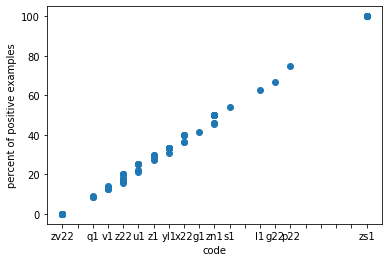

In [17]:
plt.scatter(el_levels['bin'], el_levels['pct_positive'])
plt.xlabel('code')
plt.xticks(top_levels['bin'], top_levels['index'])
plt.ylabel('percent of positive examples')

# 2. Data preparation

## Encoding the categorical variables
The categorical variables need to be converted to numbers, i.e. ***encoded***, in order to be interpretable by the models. Among the ones pre-selected above, we distinguish 3 types of categorical variables.

### Binary categorical variables
These are the most straighforward, as they can just be encoded with the two values `0` and `1`.

In [18]:
df['foreign_worker'].value_counts()

yes    963
no      37
Name: foreign_worker, dtype: int64

In [19]:
df['foreign_worker_enc'] = df['foreign_worker'].map({'no': 0, 'yes': 1})

### Ordinal categorical variables
These have more than two level, but the levels have an intrinsic ordering. This allows us to encode them using integers which are ordered accordingly.

In [20]:
df['checking_status'].value_counts()

None          394
<0DM          274
0_to_200DM    269
>200DM         63
Name: checking_status, dtype: int64

In [21]:
df['checking_status_enc'] = df['checking_status'].map({
    'None': -1,
    '<0DM': 0,
    '0_to_200DM': 1,
    '>200DM': 2
})

In [22]:
df['savings_status'].value_counts()

<100DM                        603
Unknown_or_no_savings_acct    183
100_to_500DM                  103
500_to_1000DM                  63
>1000DM                        48
Name: savings_status, dtype: int64

In [23]:
df['savings_status_enc'] = df['savings_status'].map({
    'Unknown_or_no_savings_acct': -1,
    '<100DM': 0,
    '100_to_500DM': 1,
    '500_to_1000DM': 2,
    '>1000DM': 3
})

In [24]:
df['employment'].value_counts()

1_to_4yrs     339
>7yrs         253
4_to_7yrs     174
<1yr          172
unemployed     62
Name: employment, dtype: int64

In [25]:
df['employment_enc'] = df['employment'].map({
    'unemployed': -1,
    '<1yr': 0, 
    '1_to_4yrs': 1,
    '4_to_7yrs' : 2,
    '>7yrs': 3
})

### Other categorical variables
For the others, there is no clear way to associate them to numbers, so we need to do this individually.

**`loan_history`** carries a lot of information about the outcome (even if maybe not at all what we expected!!). We can encode the levels based on the direction of the effect.

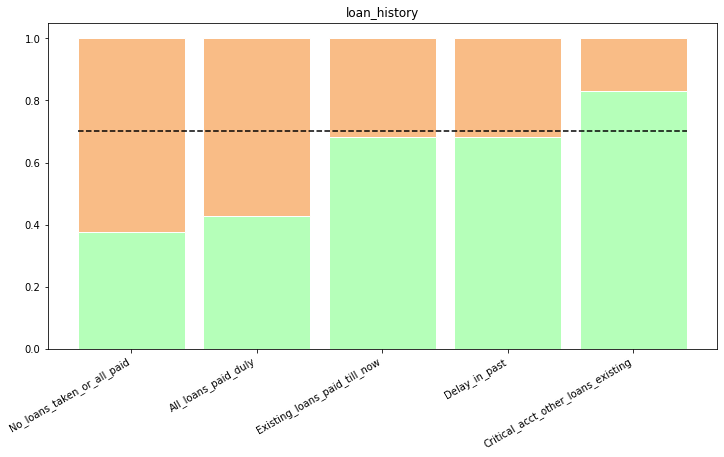

In [26]:
percentage_stacked_bar_plot('loan_history', 'label', df)

In [27]:
df['loan_history_enc'] = df['loan_history'].map({
    'No_loans_taken_or_all_paid': 0,
    'All_loans_paid_duly': 1,
    'Existing_loans_paid_till_now': 2,
    'Delay_in_past': 3,
    'Critical_acct_other_loans_existing': 4
})

**`purpose`** also seems to have a clear directionality in the effect.

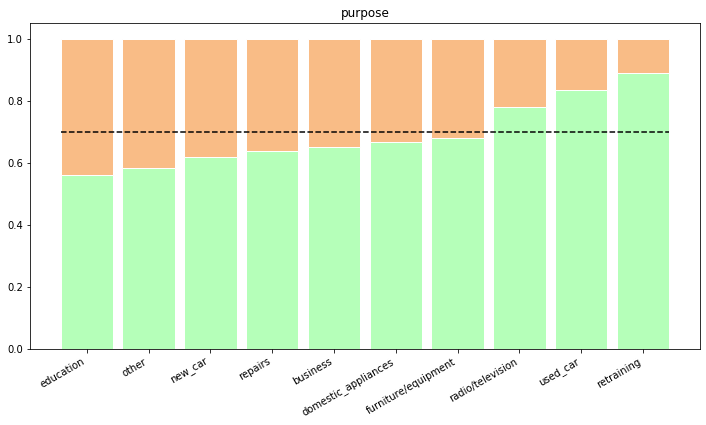

In [28]:
percentage_stacked_bar_plot('purpose', 'label', df)

In [29]:
df['purpose_enc'] = df['purpose'].map({
    'education': 0,
    'other': 1,
    'new_car': 2,
    'repairs': 3,
    'business': 4,
    'domestic_appliances': 5, 
    'furniture/equipment': 6,
    'radio/television': 7,
    'used_car': 8,
    'retraining': 9
})

For **`other_parties`**, it seems like having a guarantor helps, but having a co-applicant hurts.

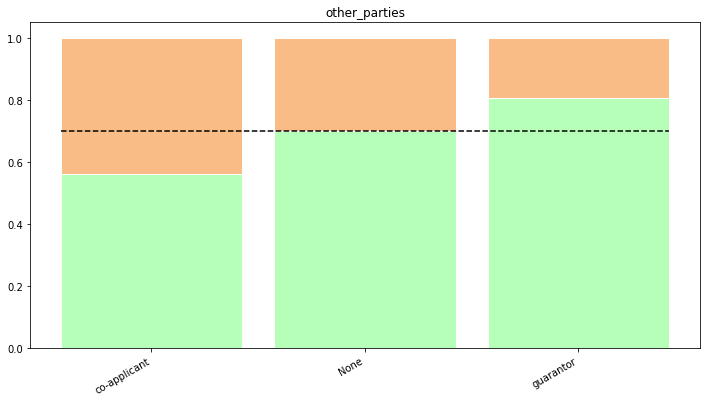

In [30]:
percentage_stacked_bar_plot('other_parties', 'label', df)

In [31]:
df['other_parties_enc'] = df['other_parties'].map({
    'None': 0,
    'guarantor': 1,
    'co-applicant': -1
})

For **`property_magnitude`**, having real_estate helps, while having no property hurts.

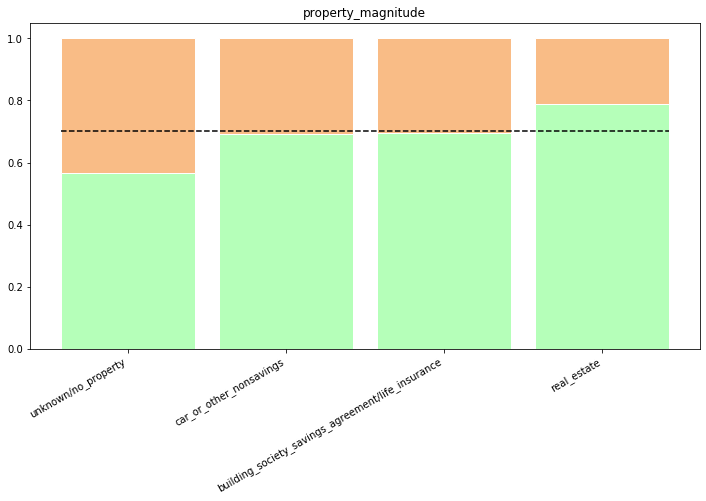

In [32]:
percentage_stacked_bar_plot('property_magnitude', 'label', df)

In [33]:
df['property_magnitude_enc'] = df['property_magnitude'].map({
    'car_or_other_nonsavings': 0,
    'real_estate': 1,
    'building_society_savings_agreement/life_insurance': 0,
    'unknown/no_property': -1
})

For **`other_payment_plans`**, bank or store hurt a bit.

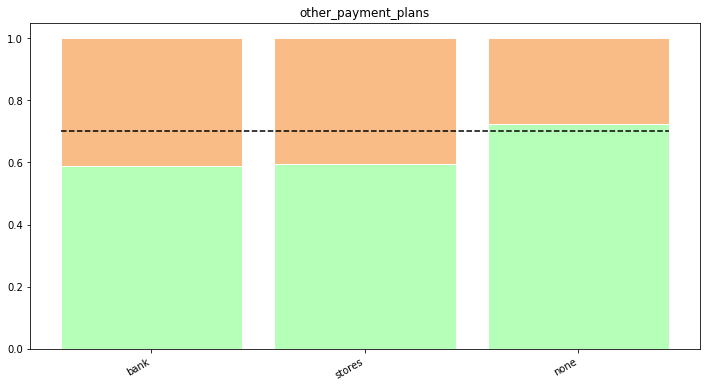

In [34]:
percentage_stacked_bar_plot('other_payment_plans', 'label', df)

In [35]:
df['other_payment_plans_enc'] = df['other_payment_plans'].map({
    'none': 0,
    'bank': -1,
    'stores': -1
})

For **`housing`**, owning a house helps, but we already know this from property magnitude, so we will not include this feature.

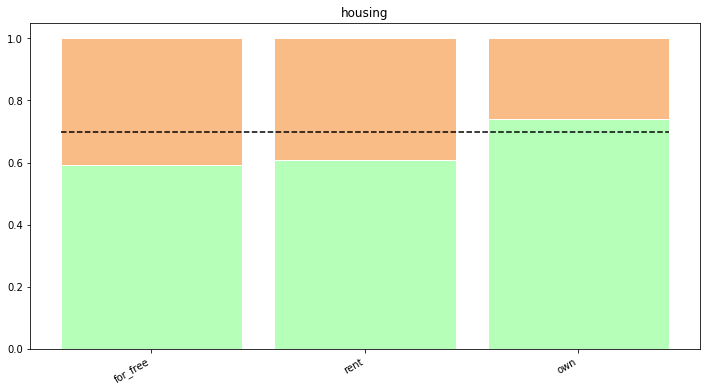

In [36]:
percentage_stacked_bar_plot('housing', 'label', df)

In [37]:
df['housing'].value_counts()

own         713
rent        179
for_free    108
Name: housing, dtype: int64

For **`existing_loans`**, we will use the cluster found above.

In [38]:
df['existing_loans_enc'] = df.existing_loans.map(el_levels['bin']).astype(int)

# 3. Metrics
Metrics are numbers that tell us how good our models are at predicting the right answer.

## Classification accuracy
Accuracy is not always a good metric, and can be misleading when predicting the minority class.

In [39]:
accuracy_score(y_true=np.array([1, 0, 0, 1]), y_pred=np.array([1, 0, 1, 1]))

0.75

## Precision
Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives. Precision expresses the proportion of the data points that were actually positive out of those labelled positive by a model. Intuitively, this is the ability of the model to find only the positive examples.

In [40]:
precision_score(y_true=np.array([1, 0, 0, 1]), y_pred=np.array([1, 1, 1, 1]))

0.5

## Recall
Recall is the number of true positives divided by the number of true positives plus the number of false negatives. Recall can be thought as of a model's ability to find all the positive examples in a dataset.

In [41]:
recall_score(y_true=np.array([1, 0, 0, 1]), y_pred=np.array([1, 1, 1, 1]))

1.0

## F-Score
Since there is always a trade-off between precision and recall, the two can be combined into a single number called the F-score, or `f1_score()`, which is the geometric mean of precision and recall.

In [42]:
f1_score(y_true=np.array([1, 0, 0, 1]), y_pred=np.array([1, 1, 1, 1]))

0.6666666666666666

In [43]:
METRIC_FUNCTIONS = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'f1': f1_score
}

# 4. Feature selection and splitting

Here are the encoded features we settled on so far.

In [44]:
FEATURES = ['duration', 'loan_amount', 'age', 'foreign_worker_enc', 'checking_status_enc',
            'savings_status_enc', 'employment_enc', 'loan_history_enc', 'purpose_enc', 'other_parties_enc',
            'property_magnitude_enc', 'other_payment_plans_enc', 'existing_loans_enc']

In [45]:
X = df[FEATURES]
y = df['label']

Normalise the features. This is not needed for tree-based models, but it might help for logistic regression.

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

So far, we have selected the features manually. But are we sure that we are not using redundant information? We can check this with PCA. Looks like all 13 features are needed to explain more than 99% of variance in the data.

In [47]:
pca = PCA(n_components=12, svd_solver='full')

In [48]:
pca.fit(X_scaled)

print(np.sum(pca.explained_variance_ratio_))
print(pca.singular_values_)

0.9727728898469725
[44.81109728 38.65924486 34.56319369 33.51265229 32.53429899 30.74270669
 30.52736192 29.92560972 28.9131882  27.74014994 26.57184066 26.13725386]


Let's generate some train / test splits. Since we only have 1000 data point, let's make 5 different random splits, so we can have a idea of how variable our metrics are. In each split, we will use 75% of data for training, and 25% for testing. We will sample in a stratified say 

In [49]:
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.25)

# 5. Lazy Human Baseline
Given the lack of a baseline from a previous business context, we will use the **"Lazy Human Baseline"**. This model will reject applications with a loan history labelled as either "Critical" or "Delay", and accept all others.

In [50]:
def lazy_human_predict(X):
    """
    Compute predictions from Lazy Human Baseline.
    
    Parameters
    ----------
    X: pandas.DataFrame
        A data frame containing the column 'loan_history_enc', containing
        the encoded levels as given above.
    
    Returns
    -------
    numpy.array
        The labels assigned by the Lazy Human.
    
    """
    return X['loan_history_enc'].map({
        0: 0,
        1: 0,
        2: 0,
        3: 1,
        4: 1
    }).values

Evaluate model over random splits.

In [51]:
METRICS_LAZY = {k: [] for k in METRIC_FUNCTIONS.keys()}

for train_IDX, test_IDX in sss.split(X, y):
    lazy_human_predictions = lazy_human_predict(X.loc[test_IDX])
    truth = y.loc[test_IDX]
    
    for key, metric in METRIC_FUNCTIONS.items():
        METRICS_LAZY[key].append(metric(truth, lazy_human_predictions))

Summary statistics of the metrics.

In [52]:
{k: np.mean(v) for k, v in METRICS_LAZY.items()}

{'accuracy': 0.48039999999999994,
 'precision': 0.20451329456555287,
 'recall': 0.25333333333333335,
 'f1': 0.22614365433591418}

In [53]:
{k: np.std(v) for k, v in METRICS_LAZY.items()}

{'accuracy': 0.028366177042386236,
 'precision': 0.034973620815367916,
 'recall': 0.044820630170590965,
 'f1': 0.03873704406816682}

# 6. Logistic regression model

In [54]:
lr = LogisticRegression(max_iter=2000)

Evaluate model over random splits.

In [55]:
METRICS_LOGISTIC = {k: [] for k in METRIC_FUNCTIONS.keys()}

for train_IDX, test_IDX in sss.split(X, y):
    # Scale features
    X_scaled = scaler.fit_transform(X.loc[train_IDX])
    lr.fit(X_scaled, y.loc[train_IDX])
    
    logistic_predictions = lr.predict(scaler.transform(X.loc[test_IDX]))
    truth = y.loc[test_IDX]
    
    for key, metric in METRIC_FUNCTIONS.items():
        METRICS_LOGISTIC[key].append(metric(truth, logistic_predictions))

In [56]:
{k: np.mean(v) for k, v in METRICS_LOGISTIC.items()}

{'accuracy': 0.8009999999999999,
 'precision': 0.7309695613639529,
 'recall': 0.5406666666666666,
 'f1': 0.6192820750360546}

In [57]:
{k: np.std(v) for k, v in METRICS_LOGISTIC.items()}

{'accuracy': 0.013616166861492241,
 'precision': 0.04832864584222669,
 'recall': 0.04268228880669097,
 'f1': 0.025340370615344637}

Check accuracy on training set to check for overfitting.

In [58]:
lr.score(X_scaled, y.loc[train_IDX])

0.816

## Precision-recall curve

In [59]:
def compute_precision_recall_curve(X, y, classifier, splitter, scaler=None,
                                   oversampler=None, thresholds=np.arange(0, 1, 0.05)):
    """
    Compute average precision-recall curve over random train/test splits.
    
    Parameters
    ----------
    X: pandas.DataFrame
        Features to use for model training and testing.
    y: pandas.Series
        Labels to use for model training and testing.
    classifier: sklearn.linear_model.LogisticRegression or other
        Sklearn classifier that supports prediction of class proabilities.
    splitter: sklearn.model_selection.StratifiedShuffleSplit or similar
        Iterable object that generates random train/test splits.
    scaler: sklearn.preprocessing.StandardScaler or similar.
        Object that scales the features.
    oversampler: imblearn.over_sampling.ADASYN or similar.
        Object that generates synthetic data.
    threshold: np.array
        The threshold values to use for the calculation.
    
    Returns
    -------
    precisions: np.array
        Mean of precision scores by threshold over the splits.
    recalls: np.array
        Mean of recall scores by threshold over the splits.

    """
    precisions = np.zeros((splitter.n_splits, len(thresholds)))
    recalls = np.zeros((splitter.n_splits, len(thresholds)))

    for (i, (train_IDX, test_IDX)) in enumerate(splitter.split(X, y)):
        if scaler:
            X_train = scaler.fit_transform(X.loc[train_IDX])
            y_train = y.loc[train_IDX]
        else:
            X_train = X.loc[train_IDX]
            y_train = y.loc[train_IDX]
        if oversampler:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)
        
        classifier.fit(X_train, y_train)
        
        for j, threshold in enumerate(thresholds):
            if scaler:
                X_test = scaler.transform(X.loc[test_IDX])
                y_test = y.loc[test_IDX]
            else:
                X_test = X.loc[test_IDX]
                y_test = y.loc[test_IDX]
                
            predictions = (classifier.predict_proba(X_test)[:,1] > threshold).astype(int)
            precisions[i,j] = precision_score(y_test, predictions, zero_division=1)
            recalls[i,j] = recall_score(y_test, predictions)
    
    return np.mean(precisions, axis=0), np.mean(recalls, axis=0)

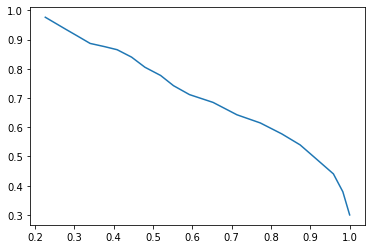

In [60]:
precisions_lr, recalls_lr = compute_precision_recall_curve(X, y, lr, sss, scaler=scaler)
plt.plot(recalls_lr, precisions_lr)

# 7. Random Forest Model

Base estimator for hyperparameter tuning.

In [61]:
# rfc = RandomForestClassifier(class_weight='balanced', n_estimators=100)

Final estimator.

In [62]:
rfc = RandomForestClassifier(
    class_weight='balanced',
    n_estimators=100,
    criterion='gini',
    max_features=2,
    max_depth=8
)

Tune hyperparameters of Random Forest.

In [63]:
grid = GridSearchCV(rfc,
                    verbose=10,
                    cv=StratifiedKFold(n_splits=3),
                    scoring=make_scorer(recall_score),
                    param_grid={
                        'criterion': ['gini', 'entropy'],
                        'max_depth': [1, 2, 5, 6, 8, 10, None],
                        'max_features': [1, 2, 3, 5, 8, 'auto']
                    })

In [64]:
# grid.fit(X.loc[train_IDX], y.loc[train_IDX])

In [65]:
# grid.best_estimator_

Use ADASYN to enrich the data set. Worth trying, but makes no difference really.

In [66]:
ada = ADASYN(sampling_strategy='all')

Train and evaluate Random Forest over random splits.

In [67]:
METRICS_RANDOM_FOREST = {k: [] for k in METRIC_FUNCTIONS.keys()}
IMPORTANCES = {k: [] for k in FEATURES}

for train_IDX, test_IDX in sss.split(X, y):
    X_res, y_res = ada.fit_resample(X.loc[train_IDX], y.loc[train_IDX])
    rfc.fit(X_res, y_res)
    
    random_forest_predictions = rfc.predict(X.loc[test_IDX])
    truth = y.loc[test_IDX]
    
    for i, features in enumerate(FEATURES):
        IMPORTANCES[features].append(rfc.feature_importances_[i])
    
    for key, metric in METRIC_FUNCTIONS.items():
        METRICS_RANDOM_FOREST[key].append(metric(truth, random_forest_predictions))

In [68]:
{k: np.mean(v) for k, v in METRICS_RANDOM_FOREST.items()}

{'accuracy': 0.8096,
 'precision': 0.6731694817610815,
 'recall': 0.716,
 'f1': 0.6926788023429296}

In [69]:
{k: np.std(v) for k, v in METRICS_RANDOM_FOREST.items()}

{'accuracy': 0.02326886331559835,
 'precision': 0.04308782399687541,
 'recall': 0.05251031644670724,
 'f1': 0.03713243602271373}

Check performance of training set to check for overfitting.

In [70]:
rfc.score(X.loc[train_IDX], y.loc[train_IDX])

0.9306666666666666

Check feature importances. Thankfully we didn't throw away `existing_loans`!!

In [71]:
MEAN_IMPORTANCES = {k: np.mean(v) for k,v in IMPORTANCES.items()}
MEAN_IMPORTANCES

{'duration': 0.07236803331763023,
 'loan_amount': 0.06746124995226917,
 'age': 0.05296684538936618,
 'foreign_worker_enc': 0.004884808200947859,
 'checking_status_enc': 0.19429012894804107,
 'savings_status_enc': 0.05827921722338762,
 'employment_enc': 0.044282825985614185,
 'loan_history_enc': 0.08886354270629296,
 'purpose_enc': 0.08987695428763655,
 'other_parties_enc': 0.017040325685313856,
 'property_magnitude_enc': 0.044404183266275,
 'other_payment_plans_enc': 0.01273705243802548,
 'existing_loans_enc': 0.2525448325991998}

In [72]:
MEAN_IMP_SORTED = {k: v for k, v in sorted(MEAN_IMPORTANCES.items(), key=lambda item: item[1], reverse=True)}

Text(0.5, 1.0, 'Mean Random Forest Feature Importances')

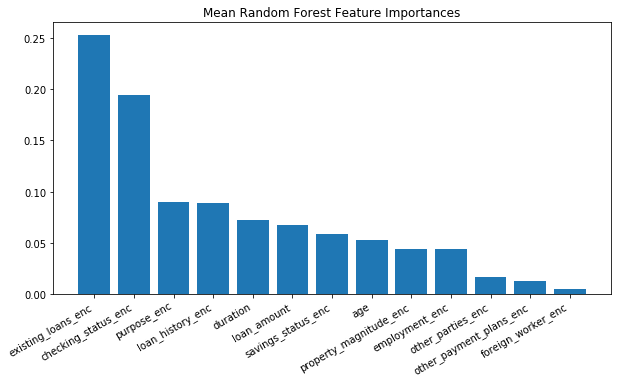

In [73]:
fig = plt.figure(figsize=(10,5))
plt.bar(MEAN_IMP_SORTED.keys(), MEAN_IMP_SORTED.values())
plt.xticks(rotation=30, ha='right')
plt.title('Mean Random Forest Feature Importances')

## Precision-recall curve

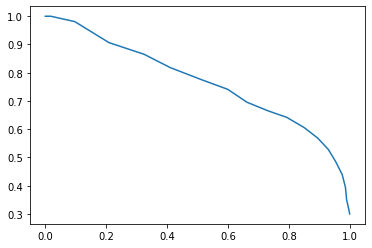

In [74]:
precisions_rfc, recalls_rfc = compute_precision_recall_curve(X, y, rfc, sss, oversampler=ada)
plt.plot(recalls_rfc, precisions_rfc)

## Compare the curves

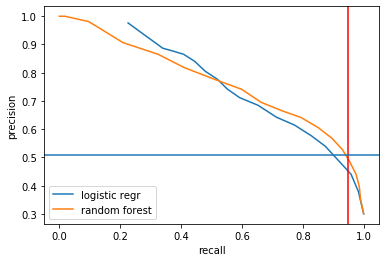

In [75]:
fig = plt.figure()
plt.plot(recalls_lr, precisions_lr)
plt.plot(recalls_rfc, precisions_rfc)
plt.xlabel('recall')
plt.ylabel('precision')
plt.axvline(0.95, color='red')
plt.axhline(0.51)
plt.legend(['logistic regr', 'random forest'])